In [7]:
import pandas as pd
import datetime as dt
import numpy as np

from csv import writer

from tensorflow.keras.models import Sequential
from keras.layers import GRU, Dense, Dropout,Bidirectional
from keras.models import load_model

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

df = pd.read_csv('../../../data/clean/btc_high.csv')

df['O-C'] = df['open'] - df['close']
MA_1 = 7
MA_2 = 14
MA_3 = 21

df[f'SMA_{MA_1}_high'] = df['high'].rolling(window=MA_1).mean()
df[f'SMA_{MA_2}_high'] = df['high'].rolling(window=MA_2).mean()
df[f'SMA_{MA_3}_high'] = df['high'].rolling(window=MA_3).mean()

df[f'SD_{MA_1}_high'] = df['high'].rolling(window=MA_1).std()
df[f'SD_{MA_3}_high'] = df['high'].rolling(window=MA_3).std()
df.dropna(inplace=True)

pre_day =7
scala_x = MinMaxScaler(feature_range=(0,1))
scala_y = MinMaxScaler(feature_range=(0,1))
cols_x = ['low', 'open', 'close', 'O-C', f'SMA_{MA_1}_high', f'SMA_{MA_2}_high', f'SMA_{MA_3}_high', f'SD_{MA_1}_high',
               f'SD_{MA_3}_high']
cols_y = ['high']
scaled_data_x = scala_x.fit_transform(df[cols_x].values.reshape(-1, len(cols_x)))
scaled_data_y = scala_y.fit_transform(df[cols_y].values.reshape(-1, len(cols_y)))

x_total = []
y_total = []

for i in range(pre_day, len(df)):
    x_total.append(scaled_data_x[i-pre_day:i])
    y_total.append(scaled_data_y[i])

    # TEST SIZE
test_size = (int)(len(scaled_data_y) * 0.2)
print(test_size)

x_train = np.array(x_total[:len(x_total)-test_size])
x_test = np.array(x_total[len(x_total)-test_size:])
y_train = np.array(y_total[:len(y_total)-test_size])
y_test = np.array(y_total[len(y_total)-test_size:])

# BUILD MODEL


601


In [8]:
model = Sequential()

model.add(GRU(units=128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(64, activation='tanh'))
model.add(GRU(units=64, return_sequences=True, input_shape=(1, len(cols_x))))
# model.add(Dropout(0.2))
# model.add(Dense(32, activation='sigmoid'))
model.add(Bidirectional(GRU(units=8, return_sequences=False)))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])
model.fit(x_train, y_train, epochs=120, steps_per_epoch=40, use_multiprocessing=True)
# ,validation_data=(x_test, y_test)
model.save('../../../models/GRU_HIGH.h5')
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)


Epoch 1/120
40/40 [==============================] - 9s 13ms/step - loss: 0.0029 - accuracy: 4.1684e-04
Epoch 2/120
40/40 [==============================] - 1s 13ms/step - loss: 3.6970e-04 - accuracy: 4.1684e-04
Epoch 3/120
40/40 [==============================] - 0s 12ms/step - loss: 3.8376e-04 - accuracy: 4.1684e-04
Epoch 4/120
40/40 [==============================] - 1s 13ms/step - loss: 3.3193e-04 - accuracy: 4.1684e-04
Epoch 5/120
40/40 [==============================] - 1s 12ms/step - loss: 3.5919e-04 - accuracy: 4.1684e-04
Epoch 6/120
40/40 [==============================] - 0s 12ms/step - loss: 3.4668e-04 - accuracy: 4.1684e-04
Epoch 7/120
40/40 [==============================] - 0s 12ms/step - loss: 2.3112e-04 - accuracy: 4.1684e-04
Epoch 8/120
40/40 [==============================] - 0s 12ms/step - loss: 2.1429e-04 - accuracy: 4.1684e-04
Epoch 9/120
40/40 [==============================] - 1s 13ms/step - loss: 2.1040e-04 - accuracy: 4.1684e-04
Epoch 10/120
40/40 [============

In [9]:


predict_high_value = model.predict(x_test)
predict_value = scala_y.inverse_transform(predict_high_value)
y_test_high_value = scala_y.inverse_transform(y_test)



19/19 [==============================] - 2s 3ms/step


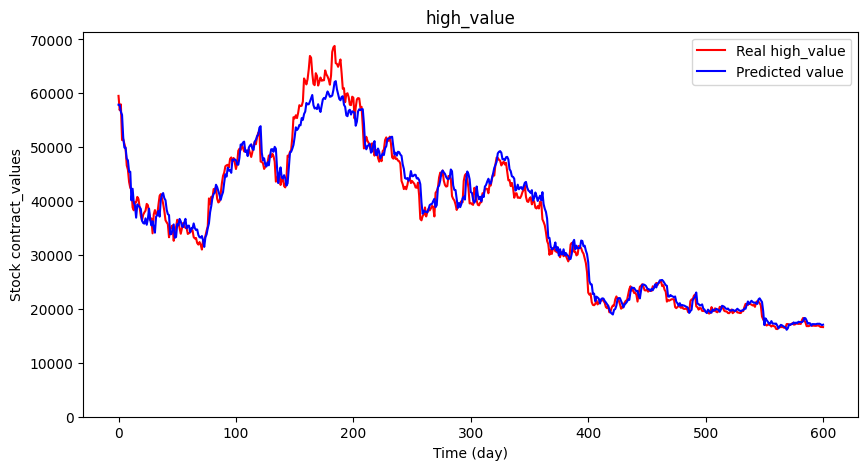

In [10]:
plt.figure(figsize=(10,5))
plt.plot(y_test_high_value, color="red", label=f"Real high_value")
plt.plot(predict_value, color="blue", label=f"Predicted value")
plt.title(f"high_value")
plt.xlabel("Time (day)")
plt.ylabel("Stock contract_values")
plt.ylim(bottom=0)
plt.legend()
plt.show()

In [11]:
mae = mean_absolute_error(y_test_high_value, predict_value)
mape = mean_absolute_percentage_error(y_test_high_value, predict_value)
mse = mean_squared_error(y_test_high_value, predict_value)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_high_value, predict_value)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 1466.11
MAPE: 3.83%
MSE: 4342352.54
RMSE: 2083.83
R2: 0.98


In [12]:

# error = pd.concat([pd.DataFrame(predict_high_value,columns=['predict_high_value'],index=None), pd.DataFrame(y_train_high_value,columns=['y_train_high_value'],index=None)], axis=1)
# error['error_high_value'] = error['predict_high_value'] - error['y_train_high_value']
# error.to_csv('./data/predict/result_high_value.csv',encoding = 'utf-8-sig')